In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom, multinomial
from tqdm import tqdm

from combinations import combinations_

In [345]:
def get_configuration_chart(vertex_states, kappa):
    '''
    Given the number of vertex-edge states, output all the unique configurations they can be
    in (Balls and bins problem)
    '''
    return np.array(combinations_(kappa, vertex_states))

print(f'C={get_configuration_chart(4, 2)}')

def eta(kappa=2):
    '''
    Generate a Bernoulli(1/2) distribution on vertices and edges
    '''
    conf_chart = get_configuration_chart(4, kappa)
    return np.vstack([multinomial.pmf(conf_chart, n=kappa, p=[1/4] * 4)/2] * 2)

def Hamiltonian(beta=1, B=0, kappa=2):
    '''
    Generate hamiltonian values corresponding to all unique states
    '''
    C = get_configuration_chart(4, kappa)
    vertex_spin_sum = C[:, 0] - C[:, 1] - C[:, 2] + C[:, 3]
    return np.vstack([-beta / 2 * vertex_spin_sum - B,
                      beta / 2 * vertex_spin_sum + B])

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa=2):
    '''
    Joint distribution for a randomly-chosen edge 
    '''
    counts = get_configuration_chart(4, kappa)
    # return p @ counts / kappa
    # Equivalent to p @ counts / kappa, but y_0v and x_v are different axes 
    return np.stack([p @ counts[:, :2], p @ counts[:, 2:]], axis=1) / kappa

def multinomial_coeff(params):
    '''
    Calculate the multinomial coefficient
    
    Inputs:
    params: a list, [x1, x2, ..., xk]
    
    Outputs:
    multinomial coefficient {x1 + x2 + ... + xk \choose x1 x2 ... xk}
    '''
    if len(params) == 1:
        return 1
    return scipy.special.binom(sum(params), params[-1]) * multinomial_coeff(params[:-1])

def vertex_distribution(p, kappa=2):
    '''
    Joint distribution for all edge-vertex pairs
    
    Input:
    p: 1-d array representing distribution on leaf configurations
    
    Output:
    kappa-d array representing the joint distribution of all edge-vertex pairs
    '''
    # Get the equivalent configuration for each combined vertex-edge state
    def counts(*vertex_marks):
        stacked = np.stack(vertex_marks, axis=0)
        ks = [np.count_nonzero(stacked == l, axis=0) for l in range(4)]
        return np.stack(ks, axis=-1)
    ks = np.fromfunction(counts, [4] * kappa)
    
    # Match the configurations with the ones from configurations list
    C = get_configuration_chart(4, kappa)
    k_reshaped = ks.reshape((-1, 4))
    indices = [(conf == C).all(axis=-1).nonzero()[0][0] for conf in k_reshaped]
    
    # Calculate probabilities for each one
    probabilities = [p[index] / multinomial_coeff(C[index]) for index in indices]
    
    return np.array(probabilities).reshape((4,) * kappa)

def objective_function(mu, beta=1, B=0, kappa=2):
    hamiltonian = Hamiltonian(beta=beta, B=B, kappa=kappa)
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta(kappa=kappa))
    pi_mu = edge_distribution(mu)
    pi_eta = edge_distribution(eta(kappa=kappa))
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr

print(f'{eta()=}')
print(f'{edge_distribution(eta())=}')
print(f'{Hamiltonian()=}')
ver_dist = vertex_distribution(np.sum(eta(kappa=2), axis=0), kappa=2)
print(f'{ver_dist=}')
print(f'{np.sum(ver_dist)=}')

C=[[0 0 0 2]
 [0 0 1 1]
 [0 0 2 0]
 [0 1 0 1]
 [0 1 1 0]
 [1 0 0 1]
 [1 0 1 0]
 [0 2 0 0]
 [1 1 0 0]
 [2 0 0 0]]
eta()=array([[0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125],
       [0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125]])
edge_distribution(eta())=array([[[0.125, 0.125],
        [0.125, 0.125]],

       [[0.125, 0.125],
        [0.125, 0.125]]])
Hamiltonian()=array([[-1., -0.,  1., -0.,  1., -1., -0.,  1., -0., -1.],
       [ 1.,  0., -1.,  0., -1.,  1.,  0., -1.,  0.,  1.]])
ver_dist=array([[0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625]])
np.sum(ver_dist)=1.0


In [ ]:
def optimize(beta, B, kappa, mu0=None, verbose=False, ftol=1e-9, constr_tol=1e-10):
    C = get_configuration_chart(4, kappa)
    if verbose:
        print(f'{C=}')
    num_configurations = len(C)
    if mu0 is None:
        # p_x0 = 1/2
        # p_up = np.random.uniform(0, 1)
        # p_xv0 = binom.pmf(np.arange(kappa+1), kappa, p_up)
        # p_xv1 = binom.pmf(np.arange(kappa+1), kappa, 1 - p_up)
        # mu0 = np.vstack([p_xv0, p_xv1]) * np.array([[p_x0], [1 - p_x0]])
        mu0 = eta(kappa=kappa)
    
    if verbose:
        print(f'{beta=}, {B=}, {kappa=}\n{mu0=}')
    
    bounds = Bounds(np.zeros_like(mu0.flatten()), np.ones_like(mu0.flatten()), keep_feasible=True)
    norm_constraint = LinearConstraint(np.ones_like(mu0.flatten()), 1, 1, keep_feasible=True)
    admissibility_linear = np.block([[C[:, 1], -C[:, 0]],
                                     [C[:, 3], -C[:, 2]]]) / kappa
    admissibility_constraint = LinearConstraint(admissibility_linear, lb=0, ub=0, keep_feasible=True)
    
    res = minimize(lambda mu: -objective_function(mu.reshape(2, num_configurations), beta=beta, B=B, kappa=kappa),
                   x0=mu0.flatten(), method='SLSQP', 
                   constraints=[norm_constraint, admissibility_constraint],
                   bounds=bounds,
                   options={'ftol': ftol, 'disp': verbose})
    
    mu = res.x.reshape(2, num_configurations)
    
    if verbose:
        print(f'{objective_function(mu)=}\n')
        print(f'{mu=}\n\n{np.sum(mu)=}\n\n{edge_distribution(mu)=}')
    
    return mu

In [346]:
mu = optimize(beta=1, B=1, kappa=2, verbose=True)

C=array([[0, 0, 0, 2],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [0, 2, 0, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]])
beta=1, B=1, kappa=2
mu0=array([[0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125],
       [0.03125, 0.0625 , 0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.03125, 0.0625 , 0.03125]])
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8675616583380091
            Iterations: 53
            Function evaluations: 1184
            Gradient evaluations: 53
objective_function(mu)=0.10597430628003279

mu=array([[1.31426762e-03, 2.62952982e-03, 1.31559940e-03, 1.94190370e-02,
        1.94213670e-02, 3.55854845e-04, 3.55770022e-04, 7.17435422e-02,
        2.62735039e-03, 2.40056374e-05],
       [5.30123527e-01, 1.94205687e-02, 1.77811275e-04, 1.43490753e-01,
        2.62978734e-03, 1.4348

### P(X1, X2 | X0)

In [180]:
mu = optimize(beta=1, B=0, kappa=2, ftol=1e-10)

x0 = 0
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = vertex_distribution(mu_edge, kappa=2)
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


mu_edge=array([0.00355234, 0.05249689, 0.19395088, 0.05249677, 0.38790176,
       0.0071047 , 0.05249682, 0.19395071, 0.05249676, 0.00355238])
leaf_dist=array([[0.00355238, 0.02624838, 0.02624841, 0.00355235],
       [0.02624838, 0.19395071, 0.19395088, 0.02624838],
       [0.02624841, 0.19395088, 0.19395088, 0.02624845],
       [0.00355235, 0.02624838, 0.02624845, 0.00355234]])
p_x1=array([0.05960151, 0.44039835, 0.44039861, 0.05960152]) p_x2=array([0.05960151, 0.44039835, 0.44039861, 0.05960152])
np.outer(p_x1, p_x2)=array([[0.00355234, 0.02624841, 0.02624842, 0.00355234],
       [0.02624841, 0.19395071, 0.19395082, 0.02624841],
       [0.02624842, 0.19395082, 0.19395094, 0.02624843],
       [0.00355234, 0.02624841, 0.02624843, 0.00355234]])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.1, 1.1)

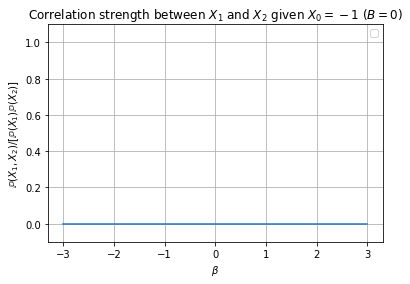

In [92]:
betas = np.linspace(-3, 3, 31)
rel_entrs = []

x0 = 0

for beta in betas:
    mu = optimize(beta=beta, B=0, kappa=2, ftol=1e-10)

    mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
    
    leaf_dist = vertex_distribution(mu_edge, kappa=2)
    
    p_x1 = np.sum(leaf_dist, axis=1)
    p_x2 = np.sum(leaf_dist, axis=0)
    indep_dist = np.outer(p_x1, p_x2)
    
    rel_entrs.append(relative_entropy(leaf_dist, indep_dist))
    
frob_dists = np.array(rel_entrs)

plt.plot(betas, frob_dists)
plt.legend()
plt.title(f'Correlation strength between $X_1$ and $X_2$ given $X_0={2*x0-1}$ ($B=0$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\\mathbb{P}(X_1, X_2) / [\\mathbb{P}(X_1)\\mathbb{P}(X_2)]$')
plt.grid(True)
plt.ylim(-0.1, 1.1)
# plt.savefig(f'../img/ising_x1_x2_x0={2*x0-1}.png')

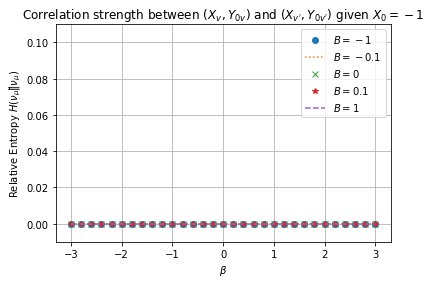

In [98]:
betas = np.linspace(-3, 3, 31)
pearson_coeff = []
Bs = [-1, -0.1, 0, .1, 1]

x0 = 0

for B, m in zip(Bs, ['o', ':', 'x', '*', '--']):
    frob_dists = []

    for beta in betas:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)

        mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
        
        leaf_dist = vertex_distribution(mu_edge, kappa=2)
        
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)

        
        frob_dists.append(relative_entropy(leaf_dist, indep_dist))
        
    frob_dists = np.array(frob_dists)

    plt.plot(betas, frob_dists, m, label=f'${B=}$')

plt.legend()
plt.title(f'Correlation strength between $(X_v, Y_{{0v}})$ and $(X_{{v\'}}, Y_{{0v\'}})$ given $X_0={2*x0-1}$')
plt.xlabel('$\\beta$')
plt.ylabel('Relative Entropy $H(\\nu_\mu \| \check{\\nu}_\mu)$')
plt.grid(True)

plt.ylim((-.01, 0.11))

plt.savefig(f'../img/EA_x1_x2_RelEntr_x0={2*x0-1}.png')

### P(X0) with respect to B

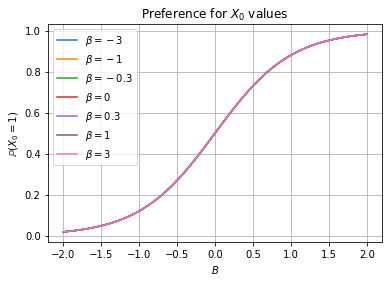

In [102]:
Bs = np.linspace(-2, 2, 51)
betas = [-3, -1, -0.3, 0, 0.3, 1, 3]

for beta in betas:
    probabilities = []
    for B in Bs:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    plt.plot(Bs, probabilities, label=f'$\\beta={beta}$')
plt.title('Preference for $X_0$ values')
plt.xlabel('$B$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B.png')

Assume that we have the form
$$\mu(x_0, \tau) = e^{\mathcal{H(x_0, \tau)}}$$
I am guessing that
$$\mu_0(x_0) = \frac1Ze^{f(\beta, B)x_0}$$
Therefore, plotting
$$\log\frac{\mu_0(+)}{1-\mu_0(+)}$$
sounds like a good idea

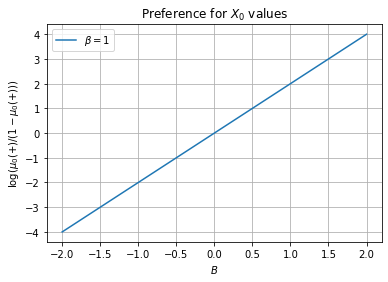

In [103]:
Bs = np.linspace(-2, 2, 51)
beta = 1

probabilities = []
for B in Bs:
    mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
    probabilities.append(np.sum(mu[1]))
    
probabilities = np.array(probabilities)
    
plt.plot(Bs, np.log(probabilities / (1 - probabilities)), label=f'$\\beta={beta}$')

plt.title('Preference for $X_0$ values')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B_logisitic.png')